# Poisson 2D implementado en Mallas Lógicamente Rectangulares.

Función que calcula una aproximación a la solución de la ecuación de Poisson en 2D utilizando Diferencias Finitas Generalizadas en mallas lógicamente rectangulares.

El problema que se resuelve es:

\begin{align}
\nabla^2 \phi = f
\end{align}

El número de vecinos varia dependiendo del nodo.

### Parámetros de entrada
    x           m x n       double      Matriz con las coordenadas en x de los nodos.
    y           m x n       double      Matriz con las coordenadas en y de los nodos.
    phi                     function    Función declarada con la condición de frontera.
    f                       function    Función declarada con el lado derecho de la ecuación.

### Parámetros de salida
    phi_ap      m x 1       double      Vector con la aproximación calculada por el método.
    phi_ex      m x 1       double      Vector con la solución exacta del problema.

# Inicialización del Problema
Se inicializa lo necesario para el problema:


1.   Se importan las librerías necesarias.
2.   Se cargan los datos de la región.
3.   Se definen las condiciones de frontera.



### Importación de Librerias
En esta parte se importan las librerias necesarias para ejecutar todo el código. En particual se importan:

*   **numpy**. Para poder hacer la mayor parte de los cálculos numéricos.
*   **math**. Permite hacer uso de diferentes funciones matemáticas.
*   **matplotlib**. Para hacer las gráficas necesarias.
*   **scipy.io**. Para usar una gran cantidad de funciones matemáticas.
*   **sys**. Para poder usar códigos en otras carpetas.
*   **Gammas**. Rutinas para el cálculo de Gammas del Método de Diferencias Finias Generalizadas.
*   **Errores**. Rutinas para calcular el Error Cuadrático Medio.
*   **Graficar**. Rutinas para graficar los resultados.

In [11]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io
import sys
sys.path.insert(0, '../Generales/')
from Gammas import Gammas_mesh as Gammas
from Errores import ECM_mesh_static as ECM
from Graficar import graph_mesh_static as Graph
from scipy.io import loadmat

### Se cargan los datos de la region

En esta parte se cargan los datos de la region desde un archivo .mat y se guardan en sus respectivas variables $x$ y $y$.

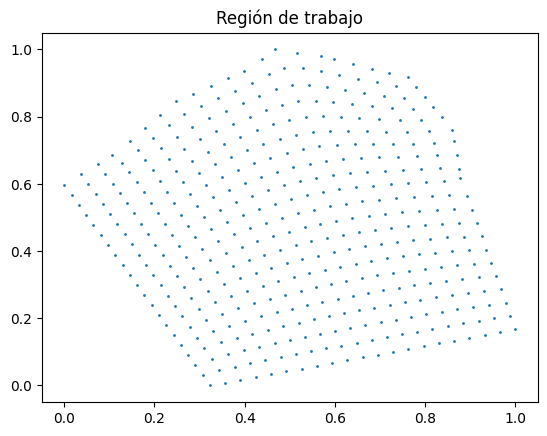

In [12]:
# Malla para trabajar
nube = 'CAB21'

# Se cargan todos los datos desde el archivo
mat = scipy.io.loadmat('../Regiones/Mallas/' + nube + '.mat')

# Se guardan los datos de los nodos
x  = mat['x']
y  = mat['y']

# Se imprimen los nodos para asegurarnos de que se cargan correctamente.
plt.scatter(x,  y,  s = 1)
plt.title('Región de trabajo')
plt.show()

### Se definen las condiciones de frontera

Las condiciones de frontera setán definidas como:
\begin{align}
  \phi = 2e^{2x+y}
\end{align}

\begin{align}
  f = 10e^{2x+y}
\end{align}

In [13]:
def phi(x,y):
  fun = 2*math.exp(2*x+y)
  return fun

def f(x,y):
  fun = 10*math.exp(2*x+y)
  return fun

## Diferencias Finitas Generalizadas
En esta parte se implementa el método de Diferencias Finitas Generalizadas sobre mallas lógicamente rectangulares.

In [14]:
def Poisson_Mesh(x, y, phi, f):
  ## Se inicializan las variables
  me       = x.shape                                                             # Se encuentra el tamaño de la malla.
  m        = me[0]                                                               # Se encuentra el número de nodos en x.
  n        = me[1]                                                               # Se encuentra el número de nodos en y.
  err      = 1                                                                   # Se inicializa el error en 1.
  tol      = np.finfo(float).eps                                                 # La tolerancia sera eps.
  phi_ap   = np.zeros([m,n])                                                     # Se inicializa phi_ap con ceros.
  phi_ex   = np.zeros([m,n])                                                     # Se inicializa phi_ex con ceros.

  ## Se fijan las condiciones de Frontera
  for i in range(m):                                                             # Para cada uno de los nodos en las fronteras en x.
    phi_ap[i, 0]   = phi(x[i, 0],   y[i, 0])                                     # Se asigna la condición de frontera en el primer y.
    phi_ap[i, n-1] = phi(x[i, n-1], y[i, n-1])                                   # Se asigna la condición de frontera en el último y.
  for j in range(n):                                                             # Para cada uno de los nodos en las fronteras en y.
    phi_ap[0,   j] = phi(x[0,   j], y[0,   j])                                   # Se asigna la condición de frontera en el primer x.
    phi_ap[m-1, j] = phi(x[m-1, j], y[m-1, j])                                   # Se asigna la condición de frontera en el último x.
  
  ## Se calculan los valores de los Gamma
  L = np.vstack([[0], [0], [2], [0], [2]])                                       # Se asignan los valores del operador dierencial.
  Gamma = Gammas(x, y, L)                                                        # Se calculan las Gammas.

  ## Se hace el Método de Diferencias Finitas Generalizadas
  while err >= tol:                                                              # Mientras que el error sea mayor que la tolerancia.
    err = 0                                                                      # Error se hace cero para poder actualizar.
    for i in range(1,m-1):                                                       # Para cada uno de los nodos en x.
      for j in range(1,n-1):                                                     # Para cada uno de los valores en y.
        t = (f(x[i, j], y[i, j]) - (              \
            Gamma[i, j, 1]*phi_ap[i + 1, j    ] + \
            Gamma[i, j, 2]*phi_ap[i + 1, j + 1] + \
            Gamma[i, j, 3]*phi_ap[i    , j + 1] + \
            Gamma[i, j, 4]*phi_ap[i - 1, j + 1] + \
            Gamma[i, j, 5]*phi_ap[i - 1, j    ] + \
            Gamma[i, j, 6]*phi_ap[i - 1, j - 1] + \
            Gamma[i, j, 7]*phi_ap[i    , j - 1] + \
            Gamma[i, j, 8]*phi_ap[i + 1, j - 1]))/Gamma[i, j, 0];                # Se calcula phi_ap en el nodo central.
        
        err = max(err, abs(t - phi_ap[i, j]));                                   # Se calcula el error.
        phi_ap[i,j] = t;                                                         # Se asigna el valor calculado previamente.

  ## Se guarda la solución exacta
  for i in range(m):                                                             # Para todos los nodos en x.
    for j in range(n):                                                           # Para todos los nodos en y.
      phi_ex[i,j] = phi(x[i,j], y[i,j])                                          # Se coloca la solución exacta.

  return phi_ap, phi_ex

## Ejecución

En esta parte se ejecutan los códigos necesarios para resolver el problema y se grafican las soluciones.

In [15]:
phi_ap, phi_ex = Poisson_Mesh(x, y, phi, f)

El error cometido para el método es de:  0.9999643996999928


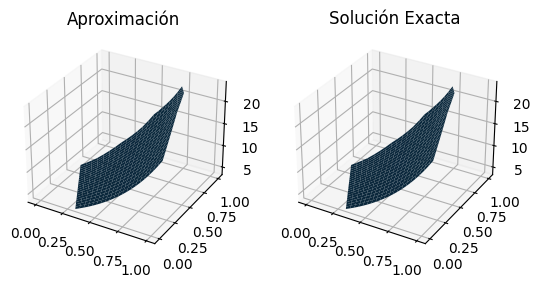

In [16]:
er = ECM(x, y, phi_ap, phi_ex)
print('El error cometido para el método es de: ', er)
Graph(x, y, phi_ap, phi_ex)